In [3]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

sys.path.insert(0, "../")

from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt


def flatten_list(list_array):
    return list(itertools.chain(*list_array))


from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]


In [4]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [5]:
testing_per_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
testing_per_ward_df["date_map"] = testing_per_ward_df["date"].map(lambda x: x.strftime("%d/%m/%y"))
testing_mat_per_ward_df         = testing_per_ward_df.pivot(index="ward", columns=["date_map"], values="num_tested").fillna(0)

admissions_per_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index()
admissions_per_ward_df["date_map"] = admissions_per_ward_df["date"].map(lambda x: x.strftime("%d/%m/%y"))
admissions_mat_per_ward_df         = admissions_per_ward_df.pivot(index="ward", columns=["date_map"], values="num_tested").fillna(0)

date_order = admissions_per_ward_df["date"].unique()
date_order = pd.DataFrame(date_order)[0].map(lambda x: x.strftime("%d/%m/%y")).values

admissions_mat_per_ward_df = admissions_mat_per_ward_df[date_order]
testing_mat_per_ward_df    = testing_mat_per_ward_df[date_order]


In [6]:
order_yaxis                = admissions_mat_per_ward_df.sum(axis=1).sort_values(ascending=False).index.values

admissions_mat_per_ward_df = admissions_mat_per_ward_df.loc[order_yaxis].reset_index(drop=True)
testing_mat_per_ward_df    = testing_mat_per_ward_df.loc[order_yaxis].reset_index(drop=True)


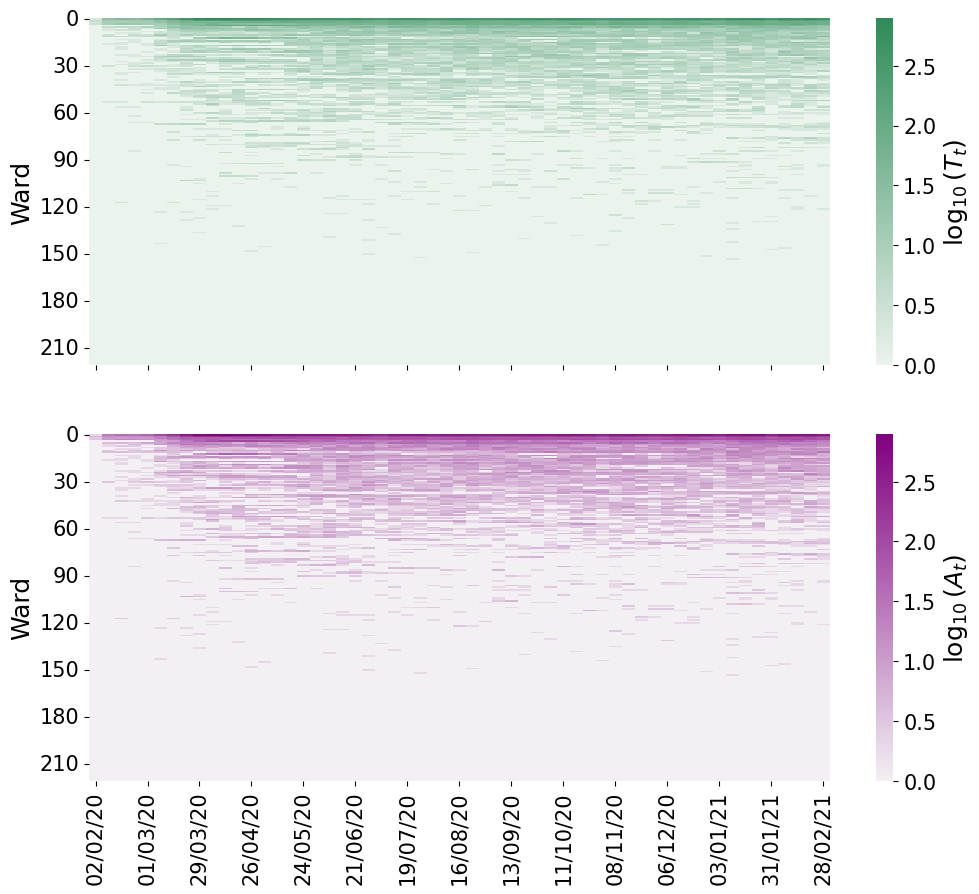

In [7]:
from utils_local import plot_utils
import matplotlib.pyplot as plt
import seaborn as sns

xx_ticks = ['02-Feb-20', '', '15-Mar-20', '', '26-Apr-20', '', '07-Jun-20', '', '19-Jul-20', '',
            '30-Aug-20', '', '11-Oct-20', '', '22-Nov-20', '', '03-Jan-21', '', '14-Feb-21']

fig, ax  = plt.subplots(2, 1, figsize=(10.5, 9.2), sharex=True, sharey=True)

g = sns.heatmap(ax=ax[0], data=np.log10(testing_mat_per_ward_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), cbar_kws={'label': r"$\log_{10}(T_t)$"})
ax[0].set_xlabel(None)

g = sns.heatmap(ax=ax[1], data=np.log10(admissions_mat_per_ward_df+1), cmap=sns.light_palette("purple", as_cmap=True), cbar_kws={'label': r"$\log_{10}(A_t)$"})
ax[0].set_ylabel("Ward")
ax[1].set_ylabel("Ward")
ax[1].set_xlabel(None)

g.set_xticks(g.get_xticks()[::2])

g.set_yticks(g.get_yticks()[::2])

#g.set_xticklabels(g.get_xticklabels()[::2])
#g.set(yticklabels=['0','','', r'$\vdots$','','','115','',r'$\vdots$','','','210'])
#g.set(yticklabels=['0','', r'$\vdots$','','115','',r'$\vdots$','','210'])
#g.set(xticklabels=xx_ticks)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

#path_to_save  = os.path.join(path_to_ms_figs, "heatmaps_test_admission.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


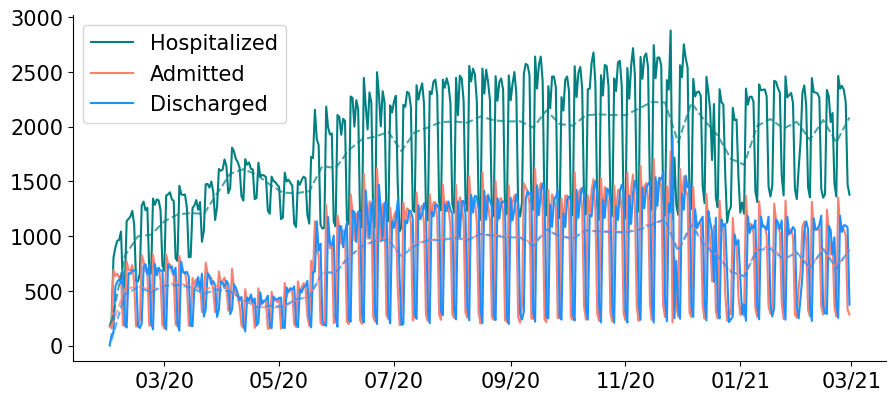

In [8]:
hosp_df = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).drop(columns=["ward"]).groupby(["date"]).sum()

fig, ax = plt.subplots(1, 1, figsize=(10.5, 4.5))

COLOR_LIST1 = ["teal", "salmon", "dodgerblue"]
ax.plot(hosp_df.index, hosp_df["num_hospitalized"], color=COLOR_LIST1[0], label="Hospitalized")
ax.plot(hosp_df.index, hosp_df["num_admitted"],     color=COLOR_LIST1[1], label="Admitted")
ax.plot(hosp_df.index, hosp_df["num_discharged"],   color=COLOR_LIST1[2], label="Discharged")

hosp_df = hosp_df.resample("W-Sun").mean()
ax.plot(hosp_df.index, hosp_df["num_hospitalized"], color=COLOR_LIST1[0], alpha=0.7, ls="--")
ax.plot(hosp_df.index, hosp_df["num_admitted"],     color=COLOR_LIST1[1], alpha=0.7, ls="--")
ax.plot(hosp_df.index, hosp_df["num_discharged"],   color=COLOR_LIST1[2], alpha=0.7, ls="--")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.tick_params(which='both', axis='x', labelrotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.legend()


In [9]:
def create_obs_building_amro(amro, ward2building_dict, path_to_data, resample="W-Sun", p_oev=0.2):
    amro_df               = pd.read_csv(path_to_data, parse_dates=["date"]).drop(columns=["Unnamed: 0"])
    amro_df               = amro_df[amro_df["amro"]==amro]
    amro_df["buildingid"] = amro_df["ward_total"].map(ward2building_dict)
    amro_df               = amro_df.groupby(["date", "buildingid"]).sum(numeric_only=True).unstack([1]).resample(resample).sum(numeric_only=True).stack().reset_index()
    amro_df["obs_name"]   = amro_df["buildingid"]
    return amro_df

selected_buildings = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital', "Rest"]
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:

        return "Rest"

In [73]:
ward2building = {w: building2building(w.split("-")[1]) for w in ward_names}

path_to_amro  = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )
amro_search   = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                    'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                    "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

obs_df = create_obs_building_amro(amro_search[0], ward2building, path_to_amro)


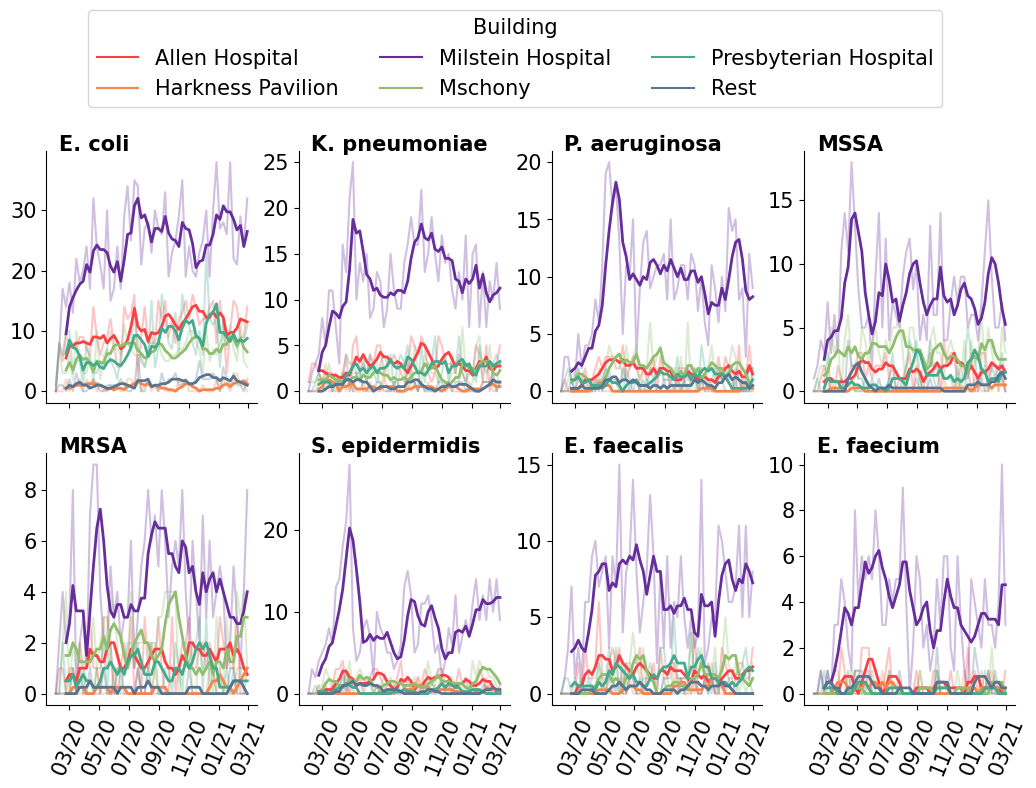

In [72]:
from utils_local.misc import amro2title, amro2cute

COLOR_LIST_B = ["#F94144", "#F9844A", "#662e9b", "#90BE6D", "#43AA8B", "#577590"] # "#F9C74F"

ward2building = {w: building2building(w.split("-")[1]) for w in ward_names}
fig, axes     = plt.subplots(2, 4, figsize=(12.5, 7.2), sharex=True, sharey=False)

for amro_id, amro in enumerate(amro_search):
    obs_df = create_obs_building_amro(amro, ward2building, path_to_amro)
    obs_df = obs_df.set_index(["date", "buildingid"]).unstack([1])[["num_positives"]].resample("W-Sun").sum().stack().reset_index()
    ax     = axes.flatten()[amro_id]

    obs_mean_df = obs_df.set_index(["date", "buildingid"]).unstack([1])[["num_positives"]].rolling(4).mean().stack().reset_index()

    sns.lineplot(ax=ax, data=obs_df, x="date", y="num_positives", hue="buildingid", alpha=0.3, legend=False, palette=COLOR_LIST_B)
    sns.lineplot(ax=ax, data=obs_mean_df, x="date", y="num_positives", hue="buildingid", lw=2, palette=COLOR_LIST_B)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    ax.tick_params(which='both', axis='x', labelrotation=67.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    ax.text(x = 18300.0, y = ax.get_ylim()[1],
                s=amro2title(amro), fontweight = "bold")

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.15, 1.6), ncol=3, title="Building")


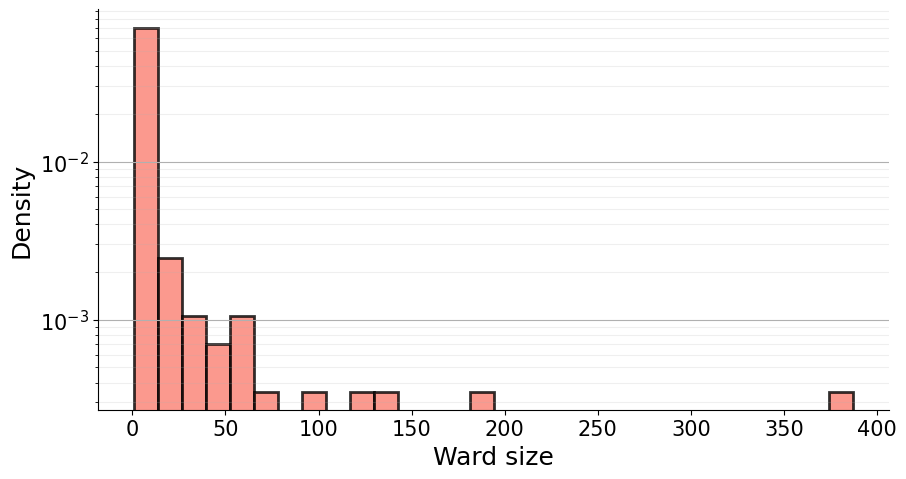

In [92]:
Hmeand_df = pd.DataFrame(np.ceil(Hmean_df)).sort_values(by=0, ascending=False).rename(columns={0: "ward_size"})

fig, ax = plt.subplots(1, 1, figsize=(10.2, 5.2))

ax.hist(Hmeand_df[Hmeand_df.ward_size>0]["ward_size"], bins=30, edgecolor="k", lw=2, facecolor="salmon", alpha=0.8, density=True, align="mid")

ax.grid(axis="y", which="minor", alpha=0.2)
ax.grid(axis="y")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Ward size")
ax.set_ylabel("Density")
ax.set_yscale('log')



In [176]:
H_w_df           = H_df.T.resample("W-Sun").sum().T
H_w_norm_df      = H_w_df / (7 * np.ceil(np.expand_dims(Hmean_df.values, -1)))
H_w_norm_plot_df = H_w_norm_df.iloc[np.where(np.ceil(np.expand_dims(Hmean_df.values, -1))>0)[0]]

Hmean_sort_df = np.ceil(Hmean_df.sort_values(ascending=False))
Hmean_sort_df = Hmean_sort_df[Hmean_sort_df>1]

Text(0.5, 0, '')

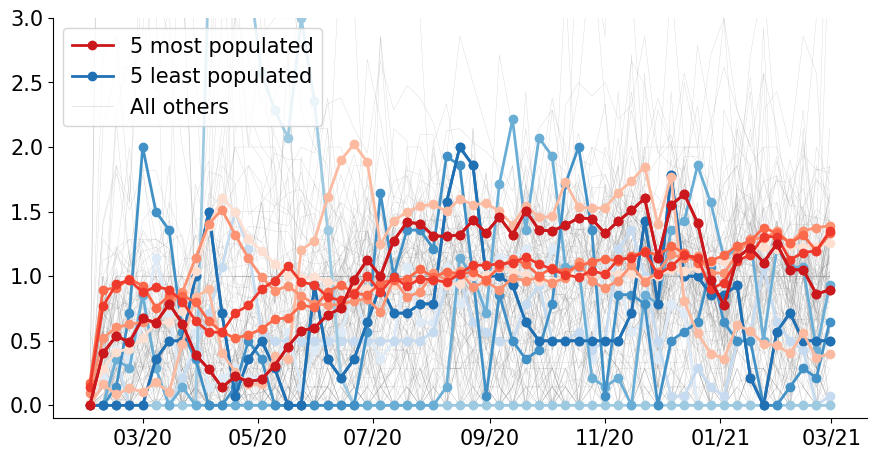

In [183]:

fig, ax = plt.subplots(1, 1, figsize=(10.5, 5.2))

ax.plot(H_w_norm_plot_df.T, alpha=0.3, color="gray", lw=0.3)

#plot top and lower 10 wards
top_k = 6

colors_top = sns.color_palette("Reds", n_colors=top_k+1, desat=True)
colors_low = sns.color_palette("Blues", n_colors=top_k+1, desat=True)

for ki in range(top_k):
    ward_top_ki = Hmean_sort_df.index.values[ki]
    ward_low_ki = Hmean_sort_df.index.values[-ki-1]

    ax.plot(H_w_norm_plot_df.loc[ward_top_ki].T, color=colors_top[ki], lw = 2, marker="o", zorder=10)
    ax.plot(H_w_norm_plot_df.loc[ward_low_ki].T, color=colors_low[ki], lw = 2, marker="o", zorder=2)

ax.plot(H_w_norm_plot_df.loc[ward_top_ki].T, color=colors_top[ki], lw = 2, marker="o", label="5 most populated", zorder=10)
ax.plot(H_w_norm_plot_df.loc[ward_low_ki].T, color=colors_low[ki], lw = 2, marker="o", label="5 least populated", zorder=1)
ax.plot(H_w_norm_plot_df.iloc[50].T, alpha=0.3, color="gray", lw=0.5, label="All others", zorder=1)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.tick_params(which='both', axis='x', labelrotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc="upper left", ncol=1)
ax.set_ylim(-0.1, 3)
ax.set_ylabel(None)
ax.set_xlabel(None)



In [180]:
# Pannel

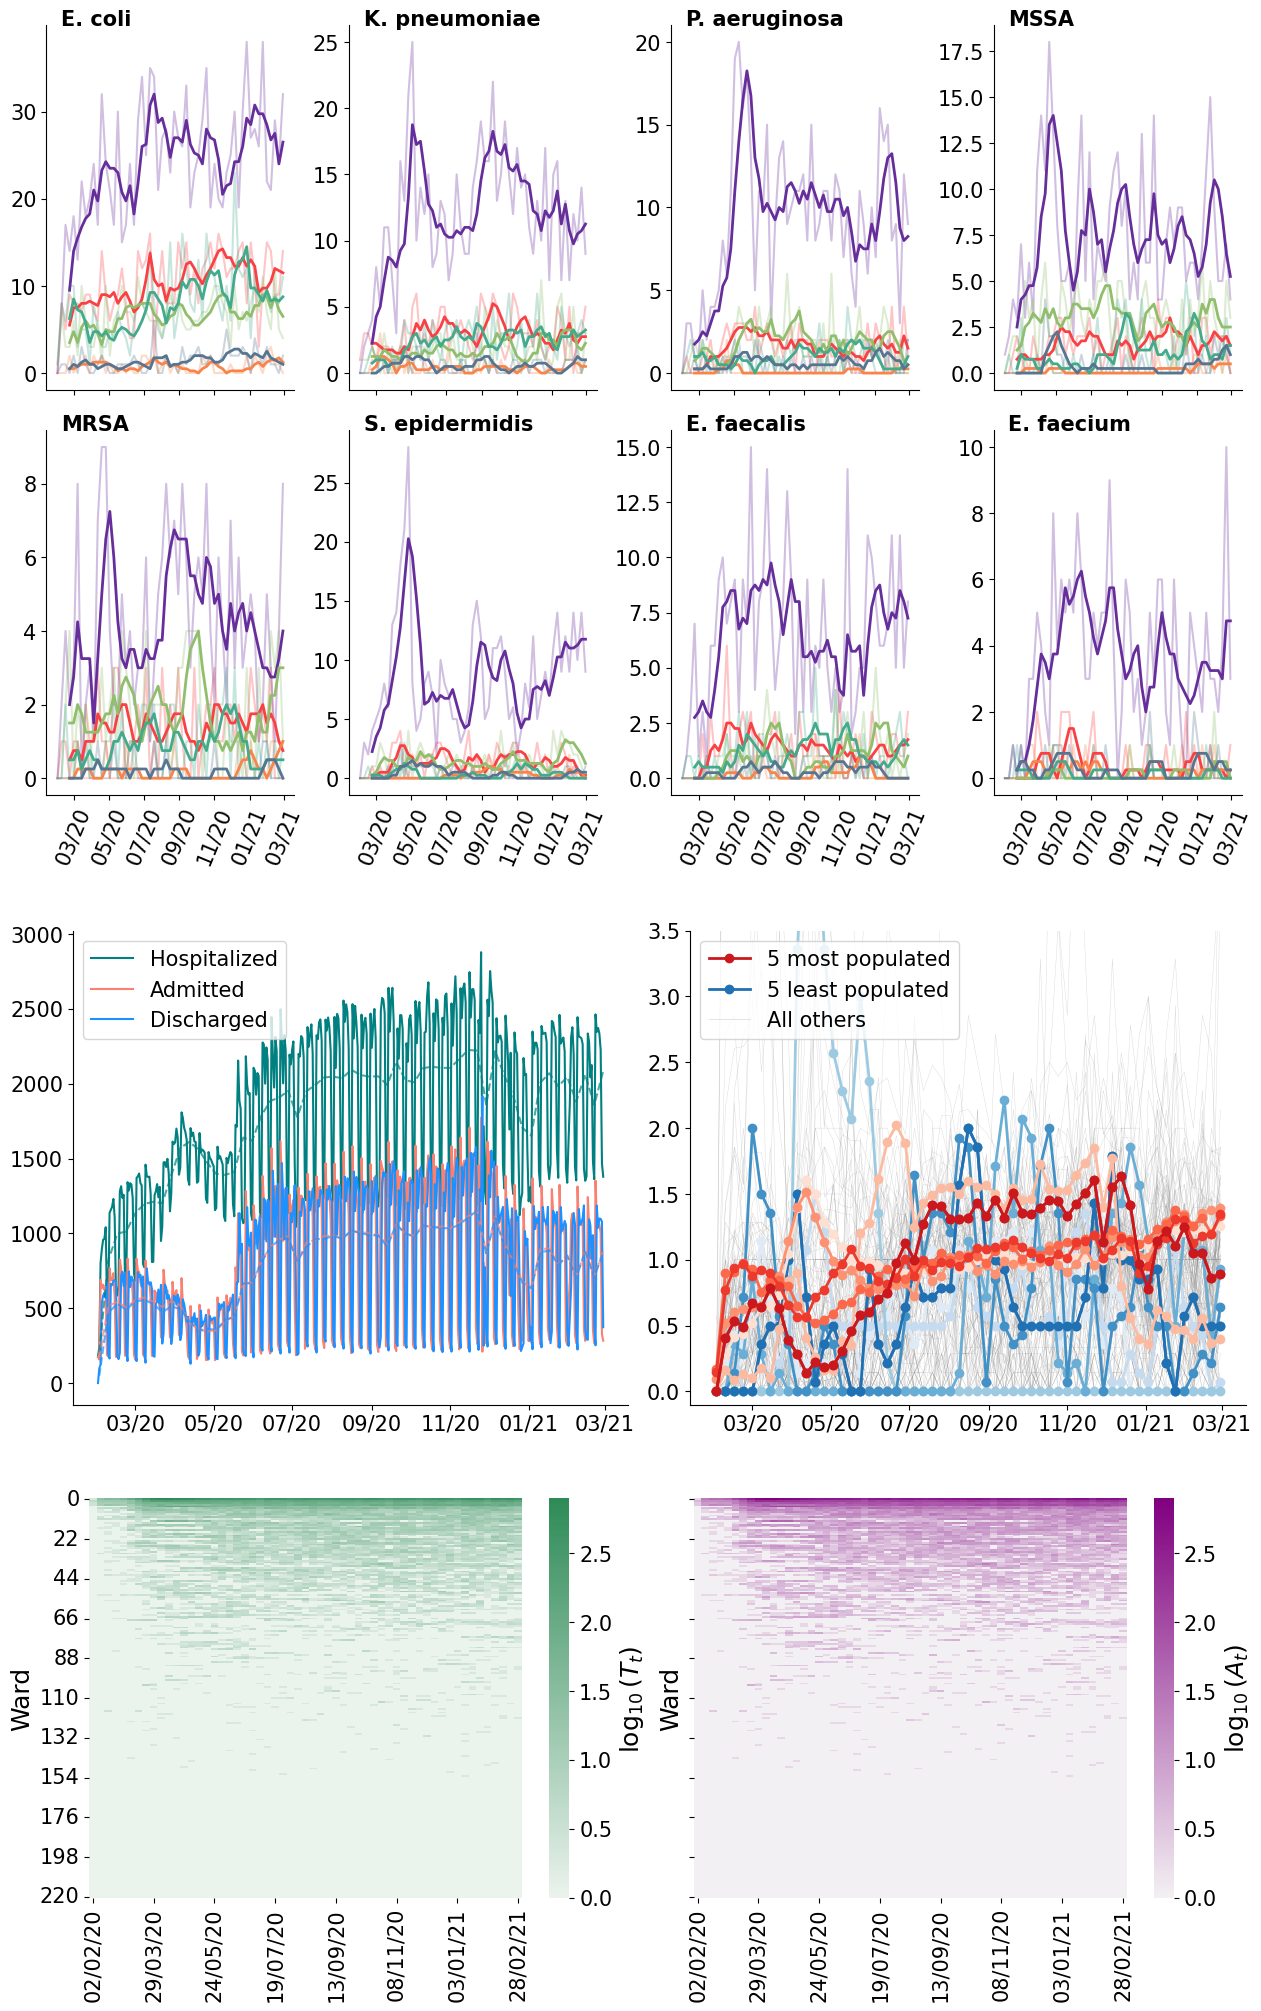

In [192]:

fig     = plt.figure(constrained_layout=True, figsize=(12.5, 20))
subfigs = fig.subfigures(3, 1, hspace=0.07, wspace=0.01, height_ratios=[0.5, 0.3, 0.3])

######################## figure A ########################
axes    = subfigs[0].subplots(2, 4, sharex=True)
for amro_id, amro in enumerate(amro_search):
    obs_df = create_obs_building_amro(amro, ward2building, path_to_amro)
    obs_df = obs_df.set_index(["date", "buildingid"]).unstack([1])[["num_positives"]].resample("W-Sun").sum().stack().reset_index()
    ax     = axes.flatten()[amro_id]

    obs_mean_df = obs_df.set_index(["date", "buildingid"]).unstack([1])[["num_positives"]].rolling(4).mean().stack().reset_index()

    sns.lineplot(ax=ax, data=obs_df, x="date", y="num_positives", hue="buildingid", alpha=0.3, legend=False, palette=COLOR_LIST_B)
    sns.lineplot(ax=ax, data=obs_mean_df, x="date", y="num_positives", hue="buildingid", lw=2, palette=COLOR_LIST_B)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    ax.tick_params(which='both', axis='x', labelrotation=67.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    ax.text(x = 18300.0, y = ax.get_ylim()[1],
                s=amro2title(amro), fontweight = "bold")

#axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.15, 1.6), ncol=3, title="Building")
############################################################
COLOR_LIST1 = ["teal", "salmon", "dodgerblue"]

axes1   = subfigs[1].subplots(1, 2, sharex=True)
hosp_df = pd.read_csv(path_to_ward_counts, parse_dates=["date"]).drop(columns=["ward"]).groupby(["date"]).sum()

axes1[0].plot(hosp_df.index, hosp_df["num_hospitalized"], color=COLOR_LIST1[0], label="Hospitalized")
axes1[0].plot(hosp_df.index, hosp_df["num_admitted"],     color=COLOR_LIST1[1], label="Admitted")
axes1[0].plot(hosp_df.index, hosp_df["num_discharged"],   color=COLOR_LIST1[2], label="Discharged")

hosp_df = hosp_df.resample("W-Sun").mean()
axes1[0].plot(hosp_df.index, hosp_df["num_hospitalized"], color=COLOR_LIST1[0], alpha=0.7, ls="--")
axes1[0].plot(hosp_df.index, hosp_df["num_admitted"],     color=COLOR_LIST1[1], alpha=0.7, ls="--")
axes1[0].plot(hosp_df.index, hosp_df["num_discharged"],   color=COLOR_LIST1[2], alpha=0.7, ls="--")

ax = axes1[1]
ax.plot(H_w_norm_plot_df.T, alpha=0.3, color="gray", lw=0.3)

#plot top and lower 10 wards
top_k = 6
colors_top = sns.color_palette("Reds", n_colors=top_k+1, desat=True)
colors_low = sns.color_palette("Blues", n_colors=top_k+1, desat=True)
for ki in range(top_k):
    ward_top_ki = Hmean_sort_df.index.values[ki]
    ward_low_ki = Hmean_sort_df.index.values[-ki-1]

    ax.plot(H_w_norm_plot_df.loc[ward_top_ki].T, color=colors_top[ki], lw = 2, marker="o", zorder=10)
    ax.plot(H_w_norm_plot_df.loc[ward_low_ki].T, color=colors_low[ki], lw = 2, marker="o", zorder=2)

ax.plot(H_w_norm_plot_df.loc[ward_top_ki].T, color=colors_top[ki], lw = 2, marker="o", label="5 most populated", zorder=10)
ax.plot(H_w_norm_plot_df.loc[ward_low_ki].T, color=colors_low[ki], lw = 2, marker="o", label="5 least populated", zorder=1)
ax.plot(H_w_norm_plot_df.iloc[50].T, alpha=0.3, color="gray", lw=0.5, label="All others", zorder=1)
ax.set_ylim([-0.1, 3.5])
for axi in axes1.flatten():
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axi.tick_params(which='both', axis='x', labelrotation=0)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend(loc="upper left")
    axi.set_ylabel(None)
    axi.set_xlabel(None)

#########
axes2    = subfigs[2].subplots(1, 2, sharey=True, sharex=True)

g1 = sns.heatmap(ax=axes2[0], data=np.log10(testing_mat_per_ward_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), cbar_kws={'label': r"$\log_{10}(T_t)$"})
axes2[0].set_xlabel(None)

g = sns.heatmap(ax=axes2[1], data=np.log10(admissions_mat_per_ward_df+1), cmap=sns.light_palette("purple", as_cmap=True), cbar_kws={'label': r"$\log_{10}(A_t)$"})
axes2[0].set_ylabel("Ward")
axes2[1].set_xlabel(None)

g1.set_xticks(g1.get_xticks()[::2])
g1.set_yticks(g1.get_yticks()[::2])

